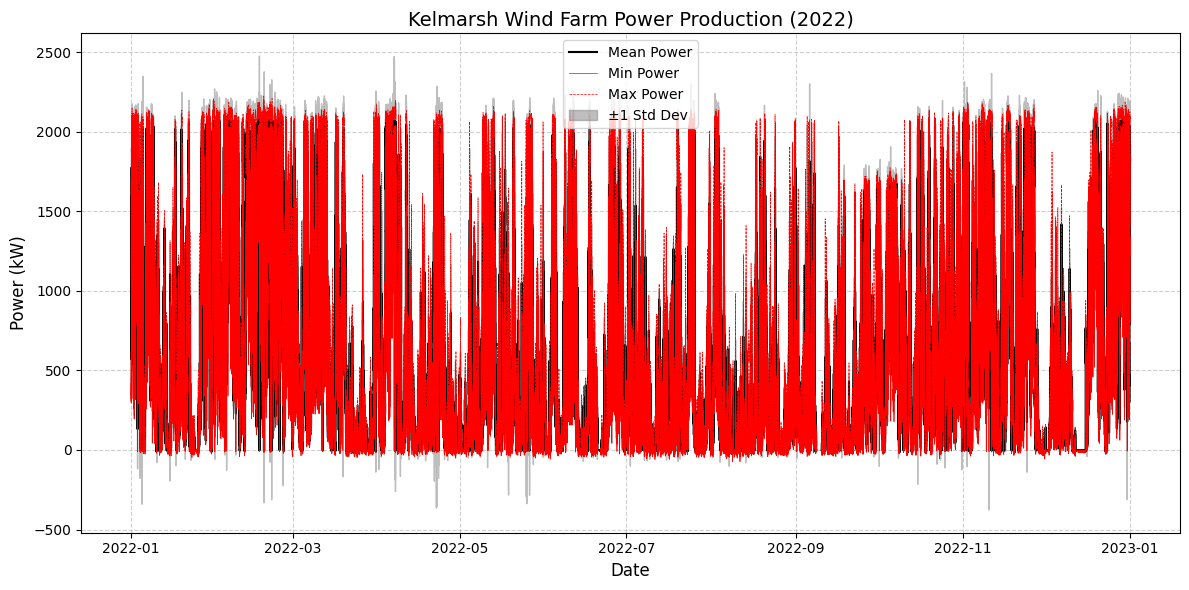

In [1]:
# ---------------------------------------------
# Part 1: Load and Plot Wind Farm Power Data
# ---------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Configuration
# -------------------------------
DATA_PATH = './km_scada_sample_2022.csv'
TARGET_COL = 'Power (kW)'
MIN_COL = 'Power, Minimum (kW)'
MAX_COL = 'Power, Maximum (kW)'
STD_COL = 'Power, Standard deviation (kW)'

# -------------------------------
# Load Data
# -------------------------------
def load_data(path: str) -> pd.DataFrame:
    """
    Load SCADA data with datetime index.

    Args:
        path (str): Path to CSV file.

    Returns:
        pd.DataFrame: DataFrame with datetime index.
    """
    return pd.read_csv(path, index_col=0, parse_dates=True)

# -------------------------------
# Plot Time Series
# -------------------------------
def plot_power_series(df: pd.DataFrame) -> None:
    """
    Plot power production with mean, min/max, and ±1 std deviation bands.
    """
    plt.figure(figsize=(12, 6))

    plt.plot(df.index, df[TARGET_COL], color='black', label='Mean Power')
    plt.plot(df.index, df[MIN_COL], color='red', linewidth=0.5, label='Min Power')
    plt.plot(df.index, df[MAX_COL], color='red', linewidth=0.5,
             linestyle='--', label='Max Power')

    plt.fill_between(
        df.index,
        df[TARGET_COL] - df[STD_COL],
        df[TARGET_COL] + df[STD_COL],
        color='gray', alpha=0.5, label='±1 Std Dev'
    )

    plt.title('Kelmarsh Wind Farm Power Production (2022)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Power (kW)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Execute
# -------------------------------
df = load_data(DATA_PATH)
plot_power_series(df)


In [8]:
# part 2 prep data
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

def split(df):
    s = df.index.min()
    t1 = s + pd.DateOffset(months=9)
    t2 = t1 + pd.DateOffset(months=2)
    train = df.loc[s:t1 - pd.Timedelta(minutes=10)]
    valid = df.loc[t1:t2 - pd.Timedelta(minutes=10)]
    test = df.loc[t2:]
    return train, valid, test

def scale(train, valid, test, col):
    sc = MinMaxScaler()
    tr = sc.fit_transform(train[[col]])
    va = sc.transform(valid[[col]])
    te = sc.transform(test[[col]])
    return tr, va, te, sc

def prep(df):
    train, valid, test = split(df)
    tr, va, te, sc = scale(train, valid, test, 'Power (kW)')

    ws = 18
    sa = 1

    # Inline windowing for train
    Xtr, ytr = [], []
    for i in range(len(tr) - ws - sa + 1):
        Xtr.append(tr[i:i+ws])
        ytr.append(tr[i+ws+sa-1])
    Xtr = np.array(Xtr)
    ytr = np.array(ytr)

    # Inline windowing for valid
    Xva, yva = [], []
    for i in range(len(va) - ws - sa + 1):
        Xva.append(va[i:i+ws])
        yva.append(va[i+ws+sa-1])
    Xva = np.array(Xva)
    yva = np.array(yva)

    # Inline windowing for test
    Xte, yte = [], []
    for i in range(len(te) - ws - sa + 1):
        Xte.append(te[i:i+ws])
        yte.append(te[i+ws+sa-1])
    Xte = np.array(Xte)
    yte = np.array(yte)

    # Tensor conversion
    Xtr = torch.tensor(Xtr, dtype=torch.float32)
    ytr = torch.tensor(ytr, dtype=torch.float32)
    Xva = torch.tensor(Xva, dtype=torch.float32)
    yva = torch.tensor(yva, dtype=torch.float32)
    Xte = torch.tensor(Xte, dtype=torch.float32)
    yte = torch.tensor(yte, dtype=torch.float32)

    return {'train': (Xtr, ytr), 'valid': (Xva, yva), 'test': (Xte, yte)},sc

d,sc = prep(df)
for s, (x, y) in d.items():
    print(s, x.shape, y.shape)


train torch.Size([39294, 18, 1]) torch.Size([39294, 1])
valid torch.Size([8766, 18, 1]) torch.Size([8766, 1])
test torch.Size([4446, 18, 1]) torch.Size([4446, 1])


In [9]:
# ---------------------------------------------
# Part 3: Train LSTM, Tune Hyperparams, Save Best Model
# ---------------------------------------------

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from itertools import product
from tqdm import tqdm
import random
import pickle

# -------------------------------
# Constants
# -------------------------------
PARAM_GRID = {
    'hidden_size': [8, 16, 32],
    'num_layers': [1, 2],
    'lr': [0.001, 0.0005],
    'batch_size': [32, 64]
}
NUM_EPOCHS = 10
N_TRIALS = 2
RANDOM_SEED = 42
SAVE_DIR = './saved_models'
MODEL_FILE = 'best_model_dict.pkl'



# -------------------------------
# LSTM Model Definition
# -------------------------------

class LSTMPredictor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])  # Use last timestep


# -------------------------------
# Train and Evaluate Function
# -------------------------------

def train_and_eval_model(hp: dict,
                         X_train_t: torch.Tensor,
                         y_train_t: torch.Tensor,
                         X_valid_t: torch.Tensor,
                         y_valid_t: torch.Tensor,
                         num_epochs: int) -> tuple[float, nn.Module, dict]:
    
    """
    Train an LSTM model using the provided hyperparameters and datasets.

    This function performs training on the given training set, skipping batches that 
    contain NaN values. After training for the specified number of epochs, it evaluates 
    the model on the validation set and returns the final validation loss along with 
    the trained model and the used hyperparameter configuration.

    Args:
        hp (dict): Dictionary containing hyperparameters:
                   'hidden_size', 'num_layers', 'lr', 'batch_size'.
        X_train_t (Tensor): Input features for training (shape: [N, seq_len, 1]).
        y_train_t (Tensor): Target values for training (shape: [N, 1]).
        X_valid_t (Tensor): Input features for validation.
        y_valid_t (Tensor): Target values for validation.
        num_epochs (int): Number of training epochs.

    Returns:
        tuple:
            - val_loss (float): Final average validation loss (MSE).
            - model (nn.Module): Trained LSTM model.
            - hp (dict): The hyperparameter dictionary used.
    """
    
    input_size = X_train_t.shape[2]

    model = LSTMPredictor(input_size, hp['hidden_size'], hp['num_layers'])
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hp['lr'])

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                              batch_size=hp['batch_size'], shuffle=True)
    valid_loader = DataLoader(TensorDataset(X_valid_t, y_valid_t),
                              batch_size=hp['batch_size'])

    # Training loop
    model.train()
    for epoch in tqdm(range(num_epochs), desc="Training"):
        for X_batch, y_batch in train_loader:
            if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
                continue
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #Validation Loop
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
                continue
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item()
            n_batches += 1

    val_loss = total_loss / n_batches if n_batches > 0 else float('inf')
    return val_loss, model, hp


# -------------------------------
# Random Hyperparameter Search
# -------------------------------

all_combinations = list(product(*PARAM_GRID.values()))
param_names = list(PARAM_GRID.keys())
random.seed(RANDOM_SEED)
sampled_combinations = random.sample(all_combinations, k=min(N_TRIALS, len(all_combinations)))

best_loss = float('inf')
best_model = None
best_hps = None

for hparams in sampled_combinations:
    
    hps = dict(zip(param_names, hparams))
    X_train_t, y_train_t = d['train']
    X_valid_t, y_valid_t = d['valid']

    val_loss, model, used_hps = train_and_eval_model( hps, X_train_t, y_train_t, X_valid_t, y_valid_t, NUM_EPOCHS)

    print(f"Tested {used_hps}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_hps = used_hps

print("\n✅ Best Hyperparameters Found:")
for k, v in best_hps.items():
    print(f"{k}: {v}")
print(f"Validation Loss: {best_loss:.4f}")

# -------------------------------
# Save Best Model, Scaler, and Hyperparameters
# -------------------------------

# Make sure directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

# Combine everything into a dictionary
model_bundle = {
    'model_state_dict': best_model.state_dict(),
    'hyperparameters': best_hps,
    'scaler': sc
}

# Save with pickle
save_path = os.path.join(SAVE_DIR, MODEL_FILE)
with open(save_path, 'wb') as f:
    pickle.dump(model_bundle, f)

print(f"✅ Best model, hyperparameters, and scaler saved to:\n{save_path}")



Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.64s/it]


Tested {'hidden_size': 32, 'num_layers': 2, 'lr': 0.001, 'batch_size': 32}, Validation Loss: 0.0064


Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


Tested {'hidden_size': 8, 'num_layers': 1, 'lr': 0.0005, 'batch_size': 64}, Validation Loss: 0.0077

✅ Best Hyperparameters Found:
hidden_size: 32
num_layers: 2
lr: 0.001
batch_size: 32
Validation Loss: 0.0064
✅ Best model, hyperparameters, and scaler saved to:
./saved_models\best_model_dict.pkl


✅ Model, hyperparameters, and scaler loaded successfully.


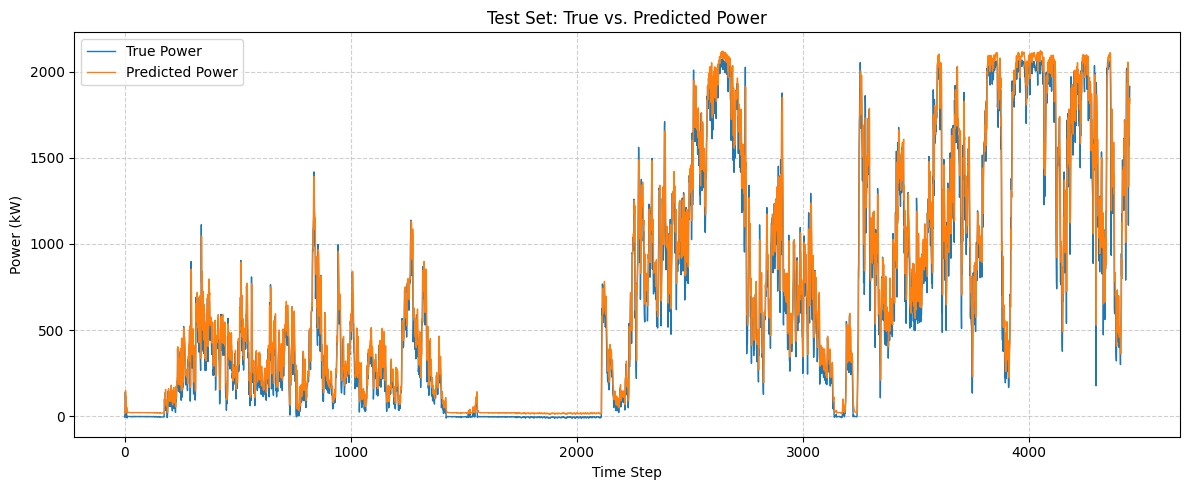

In [13]:
# ---------------------------------------------
# Part 4: Load Best Model & Plot Predictions
# ---------------------------------------------

import os
import json
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
import pickle

# -------------------------------
# Load Best Model Bundle from .pkl
# -------------------------------

MODEL_BUNDLE_PATH = os.path.join(SAVE_DIR, 'best_model_dict.pkl')

# Load the dictionary containing model state, hparams, and scaler
with open(MODEL_BUNDLE_PATH, 'rb') as f:
    model_bundle = pickle.load(f)

# Extract components
best_hps = model_bundle['hyperparameters']
scaler = model_bundle['scaler']
model_state_dict = model_bundle['model_state_dict']

# Reconstruct model using loaded hyperparameters
INPUT_SIZE = d['train'][0].shape[2]
HIDDEN_SIZE = best_hps['hidden_size']
NUM_LAYERS = best_hps['num_layers']

loaded_model = LSTMPredictor(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
loaded_model.load_state_dict(model_state_dict)
loaded_model.eval()

print("✅ Model, hyperparameters, and scaler loaded successfully.")

# -------------------------------
# Plotting Function
# -------------------------------

def plot_predictions(model: torch.nn.Module,
                     X: torch.Tensor,
                     y: torch.Tensor,
                     scaler: MinMaxScaler,
                     split_name: str = 'valid') -> None:
    """
    Plot true vs. predicted power output.
    """
    with torch.no_grad():
        y_pred = model(X)

    y_true_np = y.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    y_true_inv = scaler.inverse_transform(y_true_np)
    y_pred_inv = scaler.inverse_transform(y_pred_np)

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_inv, label='True Power', linewidth=1)
    plt.plot(y_pred_inv, label='Predicted Power', linewidth=1)
    plt.title(f'{split_name.capitalize()} Set: True vs. Predicted Power')
    plt.xlabel('Time Step')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# -------------------------------
# Choose and Plot a Split
# -------------------------------

SPLIT_TO_PLOT = "test"  # Options: "train", "valid", "test"

split_map = {
    "train": d["train"],
    "valid": d["valid"],
    "test": d["test"]
}

if SPLIT_TO_PLOT in split_map:
    X_split, y_split = split_map[SPLIT_TO_PLOT]
    plot_predictions(loaded_model, X_split, y_split, scaler, split_name=SPLIT_TO_PLOT)
else:
    print("❌ Invalid SPLIT_TO_PLOT. Choose from 'train', 'valid', or 'test'.")
